## EEG Information

1. Loading Data
    - Load csv
2. Arfitact Removal
    - transform pandas to raw mne
    - Remove Power Line Noise (50Hz, 100Hz, 150Hz, 200Hz, 250Hz)
    - Band Pass: 1 - 20 Hz

3. ICA

4. Epoching  
- tmin = -0.2
- tmax= 0.8
- events = {" non-target " : 1, " target " : 2}

In [1]:
# import library
import pandas as pd
import numpy as np
import mne
from mne import create_info
from mne.io import RawArray
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## 1. Loading Data

#### Load CSV

In [2]:
#Prepare Data 
df = pd.read_csv('group_01.csv', delimiter = ',', dtype = 'float64')
header_data = pd.read_csv('Header.csv', delimiter = ',')

#Add header to dataset
df.columns = list(header_data)
df.head()

Time    FP1_1    FP2_1    AFZ_1     F7_1     F3_1     F4_1     F8_1  \
0  0.001953  54589.0  55238.0  68817.0  61389.0  60659.0  59589.0  50781.0   
1  0.003906  54646.0  55321.0  68880.0  61461.0  60742.0  59674.0  50868.0   
2  0.005859  54790.0  55508.0  69034.0  61630.0  60919.0  59860.0  51062.0   
3  0.007812  54862.0  55602.0  69114.0  61722.0  61011.0  59951.0  51157.0   
4  0.009766  54959.0  55724.0  69222.0  61831.0  61129.0  60073.0  51279.0   

     FC5_1    FC1_1  ...     P8_2    PO7_2     O1_2     Oz_2     O2_2   PO8_2  \
0  58104.0  68243.0  ...  24600.0  26544.0  27900.0  23125.0  20075.0 -2081.4   
1  58182.0  68316.0  ...  24598.0  26539.0  27900.0  23126.0  20071.0 -2084.6   
2  58351.0  68481.0  ...  24631.0  26579.0  27924.0  23162.0  20089.0 -2063.2   
3  58438.0  68571.0  ...  24639.0  26580.0  27927.0  23151.0  20104.0 -2047.4   
4  58551.0  68685.0  ...  24667.0  26603.0  27963.0  23175.0  20138.0 -2018.4   

     PO9_2    PO10_2  Events  Target  
0  19024.0 -132130.0     0.0     0.0  
1  19019.0 -132070.0     0.0     0.0  
2  19067.0 -132370.0     0.0     0.0  
3  19069.0 -132540.0     0.0     0.0  
4  19098.0 -133000.0     0.0     0.0  

[5 rows x 67 columns]

In [3]:
df = df.drop(['Time'], axis = 1) # Drop Time column
#print(group1.columns)


#Prepare standard 10-20 systems with 32 electrodes
# chennels named according to the experiment
header = ['Fp1', 'Fp2', 'AFz', 'F7', 'F3', 'F4', 'F8', 
          'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 
          'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 
          'P3', 'Pz', 'P4', 'P8', 'PO7', 'O1', 'Oz', 
          'O2', 'PO8', 'PO9', 'PO10','Target']

In [4]:
#For Subject1

df_s1 = df.iloc[:, :32]  # Slicing data for subject1
df_s1['Target'] = df['Target'] # Add Target column
df_s1.columns = header # Add column names
df_s1.head()

Fp1      Fp2      AFz       F7       F3       F4       F8      FC5  \
0  54589.0  55238.0  68817.0  61389.0  60659.0  59589.0  50781.0  58104.0   
1  54646.0  55321.0  68880.0  61461.0  60742.0  59674.0  50868.0  58182.0   
2  54790.0  55508.0  69034.0  61630.0  60919.0  59860.0  51062.0  58351.0   
3  54862.0  55602.0  69114.0  61722.0  61011.0  59951.0  51157.0  58438.0   
4  54959.0  55724.0  69222.0  61831.0  61129.0  60073.0  51279.0  58551.0   

       FC1      FC2  ...       P4       P8      PO7       O1       Oz  \
0  68243.0  70366.0  ...  49613.0  53932.0  57899.0  57379.0  54521.0   
1  68316.0  70435.0  ...  49705.0  54017.0  57997.0  57480.0  54617.0   
2  68481.0  70597.0  ...  49895.0  54200.0  58188.0  57672.0  54790.0   
3  68571.0  70681.0  ...  49979.0  54284.0  58260.0  57744.0  54860.0   
4  68685.0  70793.0  ...  50103.0  54404.0  58378.0  57868.0  54985.0   

        O2      PO8      PO9     PO10  Target  
0  54029.0  55296.0  53193.0  50795.0     0.0  
1  54125.0  55391.0  53275.0  50886.0     0.0  
2  54303.0  55582.0  53470.0  51077.0     0.0  
3  54377.0  55666.0  53550.0  51164.0     0.0  
4  54499.0  55787.0  53676.0  51282.0     0.0  

[5 rows x 33 columns]

## 2. Artifact Removal

In [5]:
#transform pandas to mne type
def df_to_raw(df):
    
    sfreq = 512  # according to the experiment
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim'] 
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    # raw.plot()
    raw.plot_psd()

    return raw

_______________________RawArray for Subject1______________________
Creating RawArray with float64 data, n_channels=33, n_times=454431
    Range : 0 ... 454430 =      0.000 ...   887.559 secs
Ready.
Effective window size : 4.000 (s)


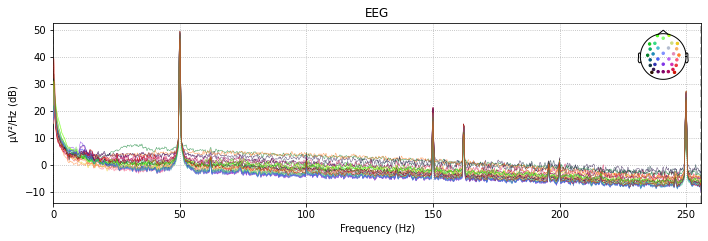

In [6]:
print("_______________________RawArray for Subject1______________________")
raw_s1 = df_to_raw(df_s1)

#### 1. Power Line noise

Remove the 50Hz power line noise and we will also remove its harmonics, i.e., 100Hz, 150Hz etc. Since our signal is 260Hz (520Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 260 Hz.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Effective window size : 4.000 (s)


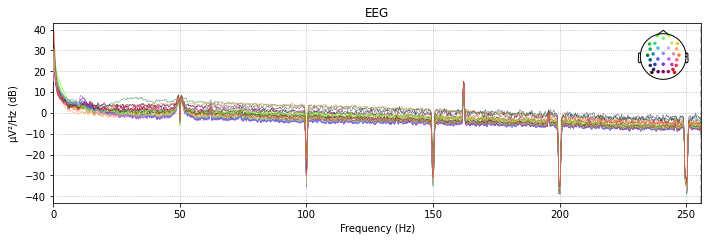

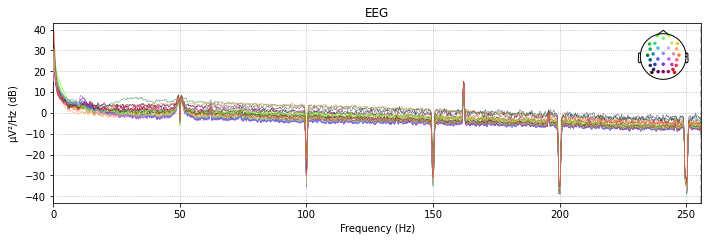

In [7]:
raw_s1.notch_filter(np.arange(50, 260, 50), filter_length='auto', phase='zero') # 520 / 2
raw_s1.plot_psd()

#### 2. Slow drift

Using matplotlib as 2D backend.


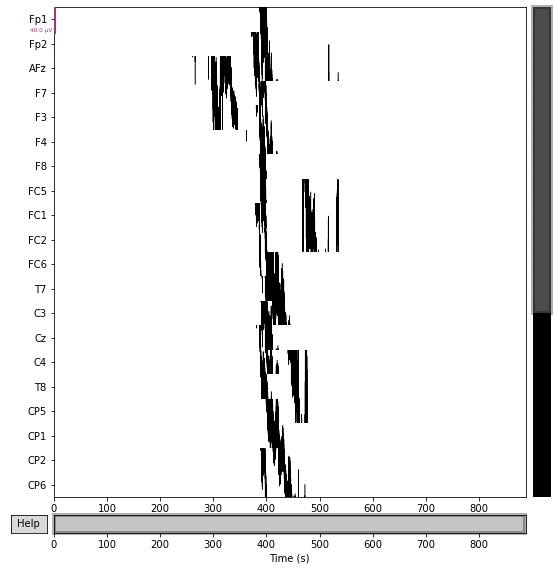

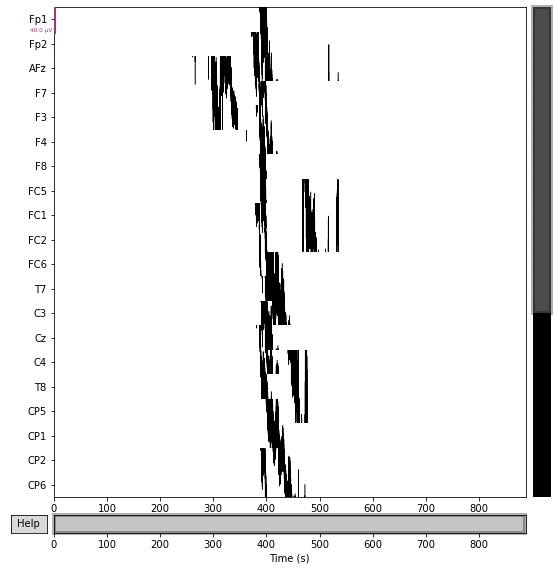

In [8]:
eeg_channels = mne.pick_types(raw_s1.info, eeg=True)
raw_s1.plot(duration=1200, order=eeg_channels) # the duration for one session is around five minutes, so 20mins(1200s) for four sessions

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16897 samples (33.002 sec)



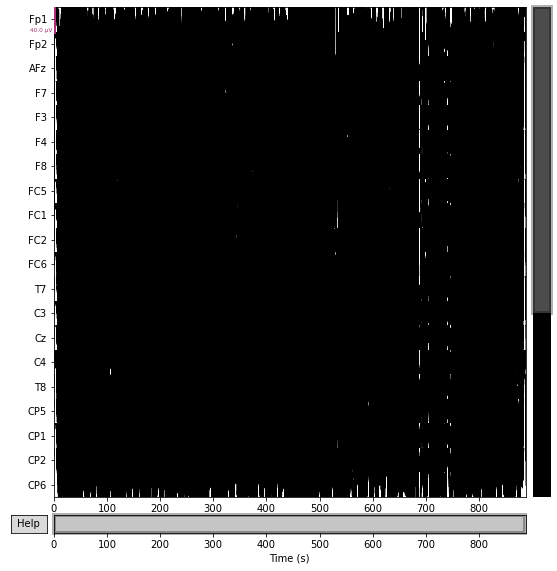

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 8449 samples (16.502 sec)



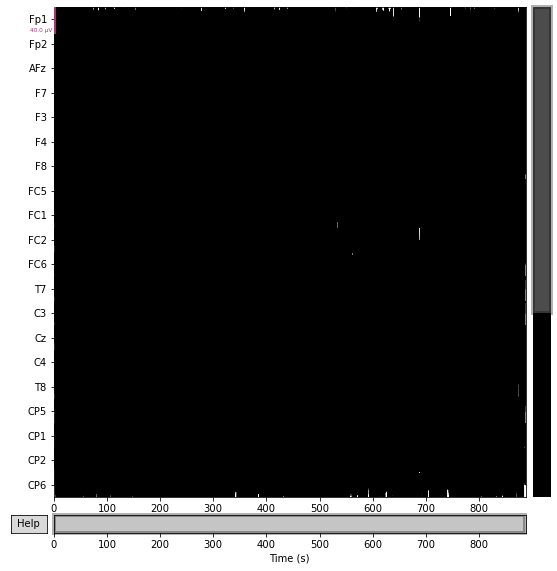

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)



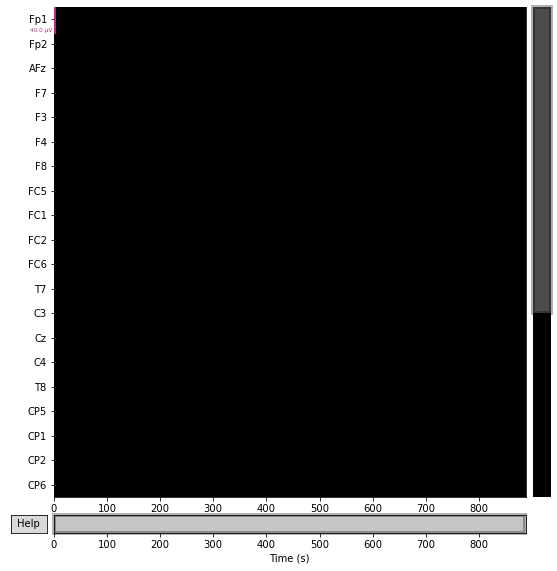

In [9]:
for cutoff in (0.1, 0.2, 1):
    raw_highpass = raw_s1.copy().filter(l_freq=cutoff, h_freq=None)
    fig = raw_highpass.plot(duration=1200, order=eeg_channels)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('High-pass filtered at {} Hz'.format(cutoff), size='xx-large',
                 weight='bold')

Looks like 0.2Hz was quite quite good to fully remove the slow drifts. Usually, 0.2Hz is a good measure since most of the brain frequency lies around 0.2 to 40Hz. We shall filter our brain signal to 1 - 15 Hz according to the paper https://hal.inria.fr/hal-00756669/document

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Effective window size : 4.000 (s)


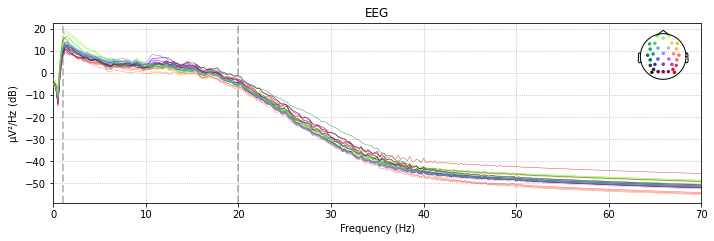

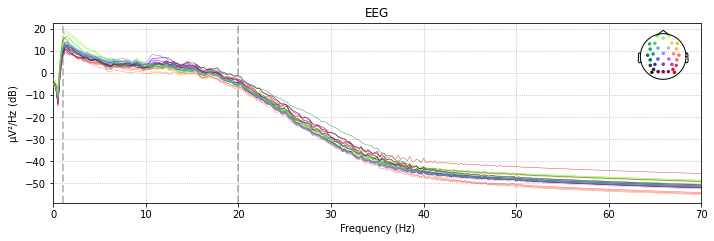

In [10]:
raw_s1.filter(1,20, method = 'iir')
raw_s1.plot_psd(fmax = 70)

#### EEG Artifacts

The types of artifacts that contaminate EEG data
 - blinks
 - muscle movements
 - brief amplifier saturations
 - line noise

### 3. Independent component analysis

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Effective window size : 4.000 (s)


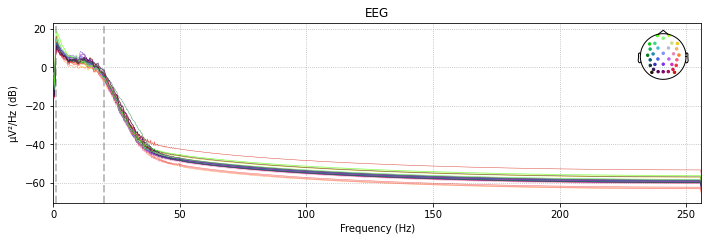

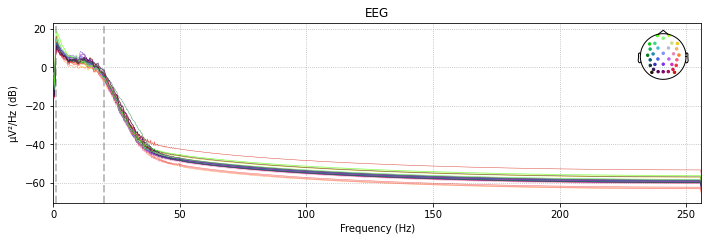

In [11]:
from mne.preprocessing import ICA

filt_raw = raw_s1.copy()
filt_raw.load_data().filter(l_freq=1.,h_freq=None)
filt_raw.plot_psd()

In [12]:
ica = ICA(n_components = 32, random_state = 32)
ica.fit(filt_raw)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 37.2s.


<ICA | raw data decomposition, method: fastica (fit in 83 iterations on 454431 samples), 32 ICA components explaining 100.0 % of variance (32 PCA components available), channel types: eeg, no sources marked for exclusion>

Creating RawArray with float64 data, n_channels=32, n_times=454431
    Range : 0 ... 454430 =      0.000 ...   887.559 secs
Ready.


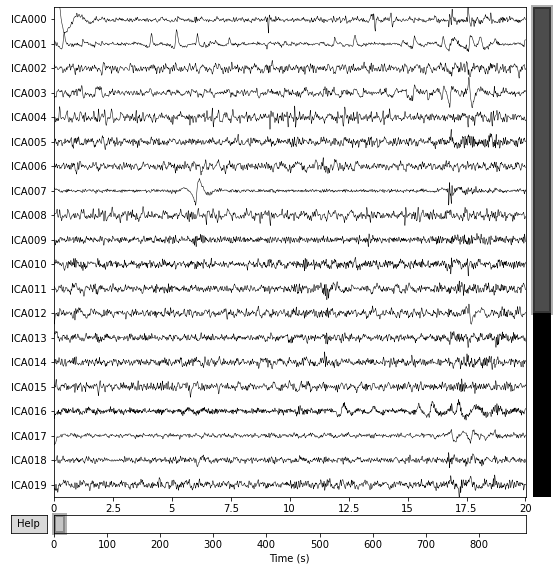

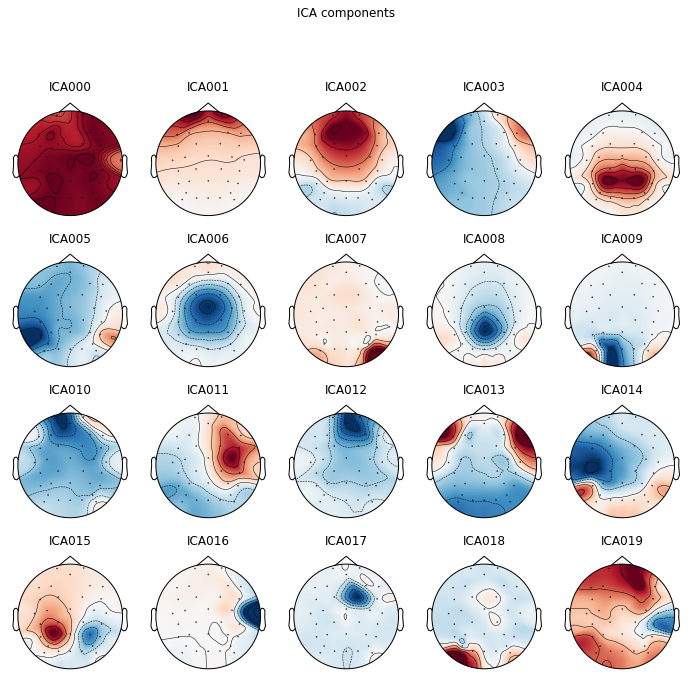

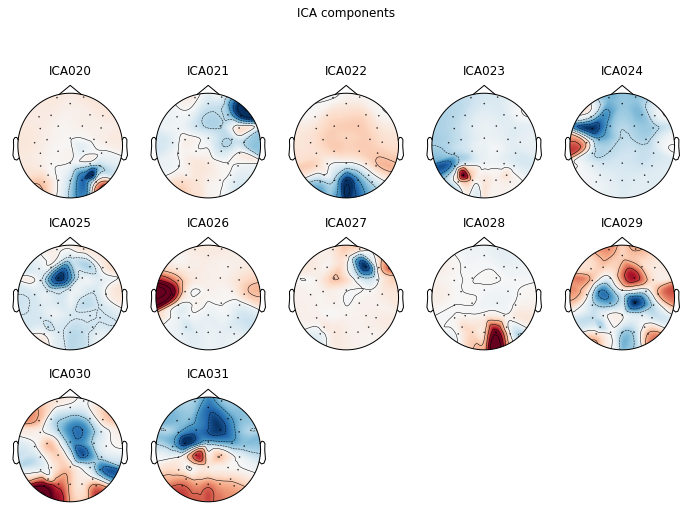

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x526.68 with 12 Axes>]

In [13]:
ica.plot_sources(filt_raw)
ica.plot_components()

In [14]:
# ica.plot_properties(filt_raw, picks = [0,1])

In [15]:
# ica.plot_overlay(filt_raw, exclude=[4,5], picks='eeg')

In [16]:
orig_raw = raw_s1.copy()  #we apply ica to raw
ica.apply(raw_s1)

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


<RawArray | 33 x 454431 (887.6 s), ~114.5 MB, data loaded>

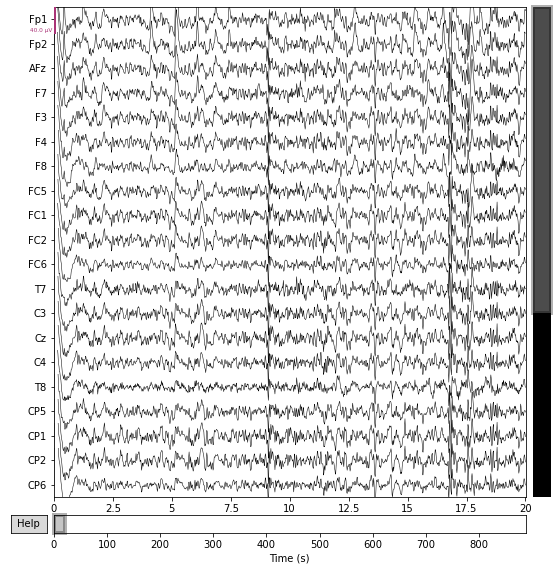

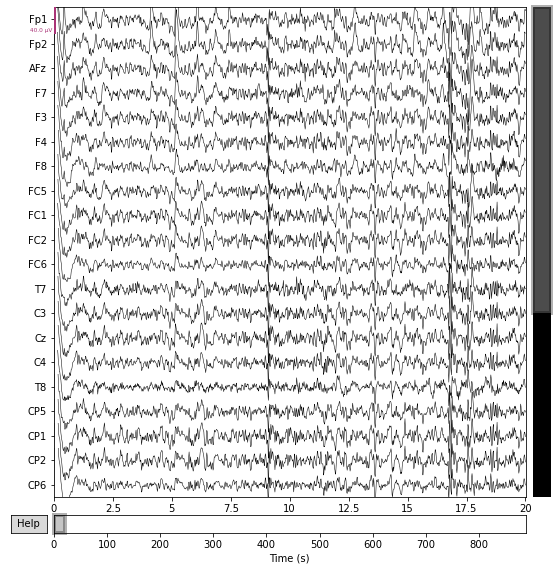

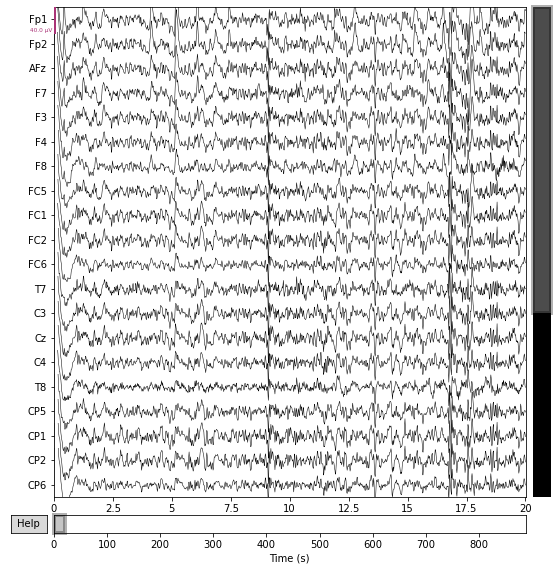

In [17]:
orig_raw.plot(order=eeg_channels, duration=20)
raw_s1.plot(order=eeg_channels, duration=20)

## 4. Epoching

In [18]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    
    #reject_criteria = dict(mag=4000e-15,     # 4000 fT
    #                       grad=4000e-13,    # 4000 fT/cm
    #                       eeg=100e-6,       # 150 μV
    #                       eog=250e-6)       # 250 μV

    reject_criteria = dict(eeg=100e-6)  #most voltage in this range is not brain components

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [19]:
# ### https://www.sciencedirect.com/science/article/pii/S1746809410000558
event_id = {'Non-Target' : 1, "Target" : 2}
tmin = -0.1
tmax = 0.7
picks = eeg_channels
epochs = getEpochs(raw_s1, event_id, tmin, tmax, picks)

636 events found
Event IDs: [1 2]
sample drop %:  0.0


In [20]:
X = epochs.get_data()
y = epochs.events[:, -1]

print(X.shape)
print(y.shape)

(636, 32, 410)
(636,)


#### Plotting ERP of targets vs. non-targets

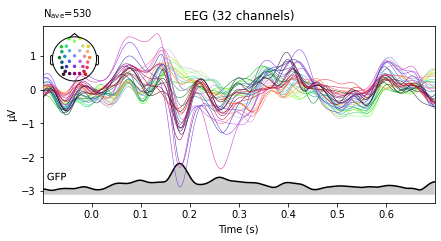

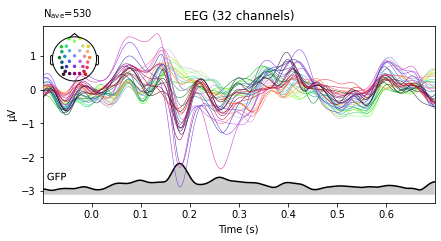

In [21]:
evoked_non = epochs['Non-Target'].average()
evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')

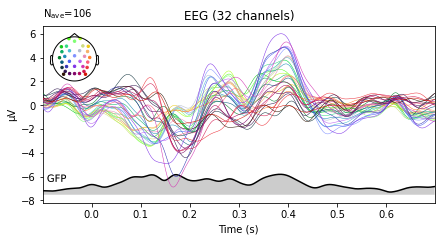

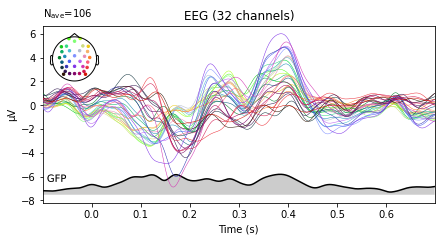

In [22]:
# evoked_non = epochs['Non-Target'].average()
# evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')
evoked_target = epochs['Target'].average()
evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s')

#### Plotting scalp topographies

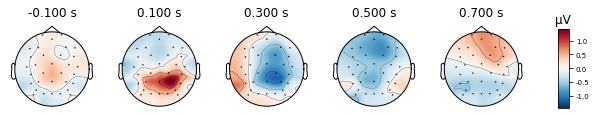

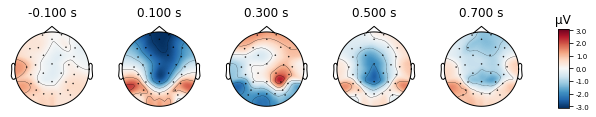

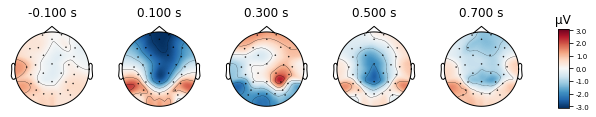

In [23]:
times = np.linspace(-0.1, 0.7, 5)
evoked_non.plot_topomap(ch_type='eeg', times=times, colorbar=True)
evoked_target.plot_topomap(ch_type='eeg', times = times, colorbar= True)

#### Plotting ERP together with topographies

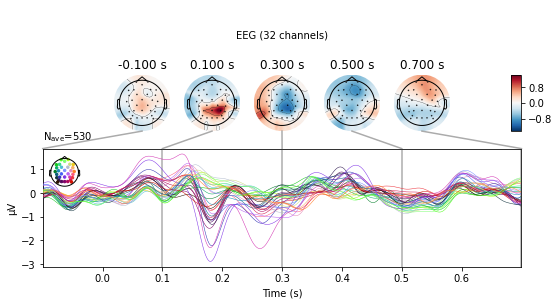

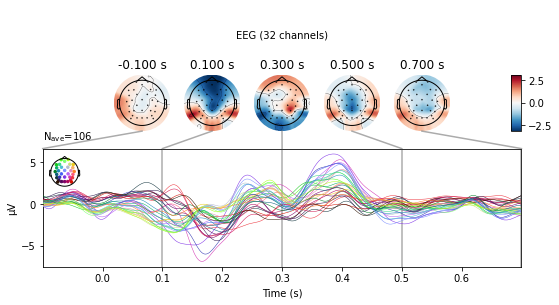

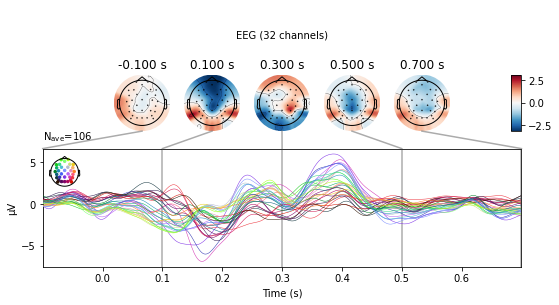

In [24]:
evoked_non.plot_joint(times=times)
evoked_target.plot_joint(times=times)

#### Image Plots

Not setting metadata
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


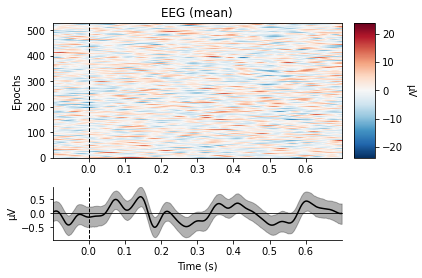

Not setting metadata
Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


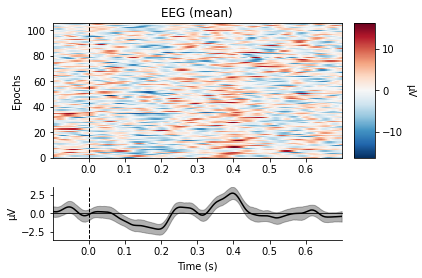

[<Figure size 432x288 with 3 Axes>]

In [25]:
epochs['Non-Target'].plot_image(picks='eeg', combine='mean')
epochs['Target'].plot_image(picks='eeg', combine='mean')

##### Comparing Evoked objects

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


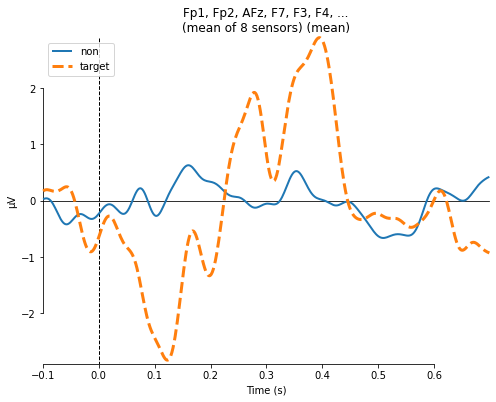

More than 6 channels, truncating title ...
combining channels using "median"
combining channels using "median"


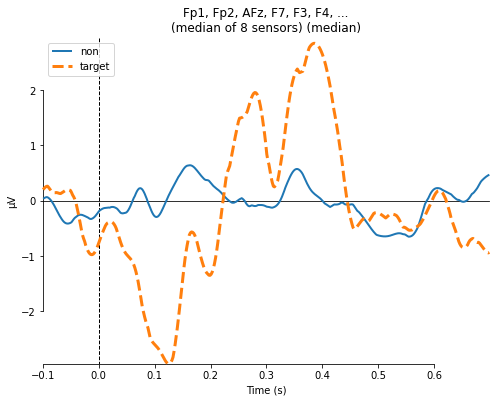

combining channels using "gfp"
combining channels using "gfp"


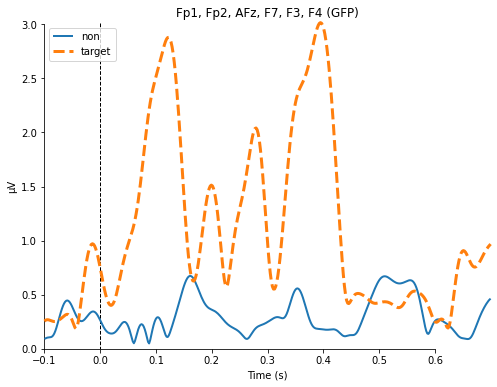

More than 6 channels, truncating title ...
combining channels using "<function custom_func at 0x7f388706ed30>"
combining channels using "<function custom_func at 0x7f388706ed30>"


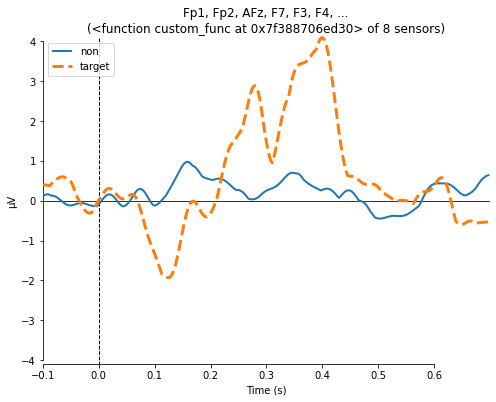

In [26]:
def custom_func(x):
    return x.max(axis=1)

total_evoked = {"non": evoked_non, "target": evoked_target}
for combine in ('mean', 'median', 'gfp', custom_func):
    mne.viz.plot_compare_evokeds(total_evoked, picks=[0,1,2,3,4,5,6,7], combine=combine,
                                colors=dict(non=0, target=1),
                                linestyles=dict(non='solid', target='dashed'),
                                 styles=dict(non=dict(linewidth=2),target=dict(linewidth=3)))

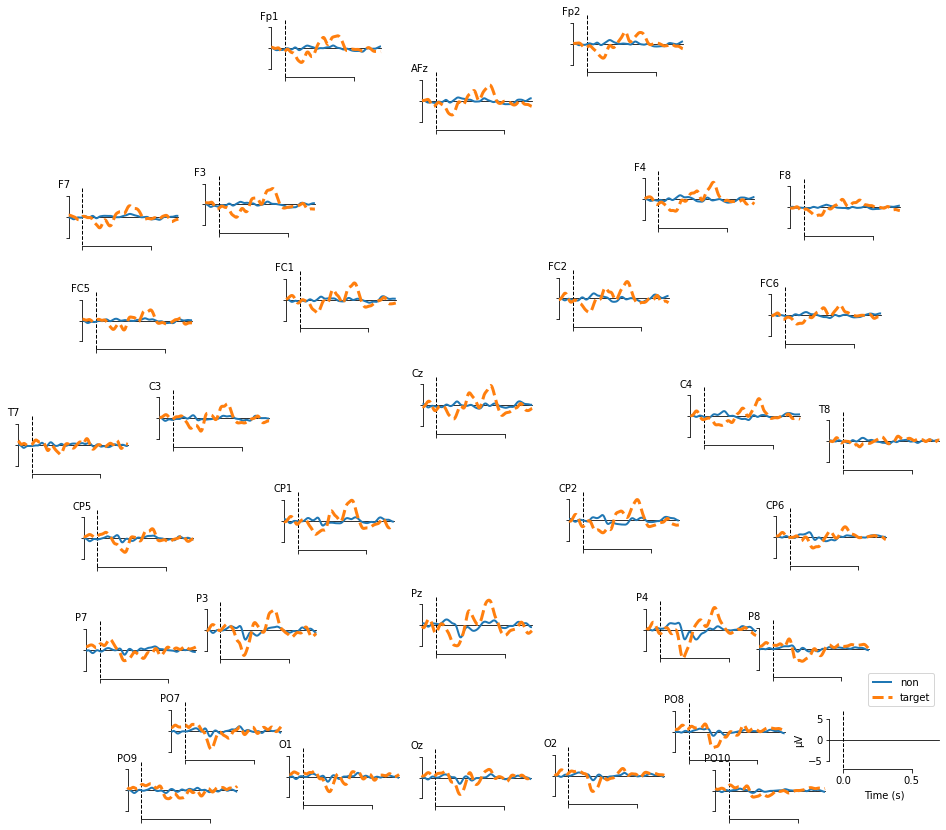

[<Figure size 1296x1008 with 33 Axes>]

In [27]:
mne.viz.plot_compare_evokeds(total_evoked, picks='eeg',
                                colors=dict(non=0, target=1), axes='topo',
                                linestyles=dict(non='solid', target='dashed'),
                            styles=dict(non=dict(linewidth=2),target=dict(linewidth=3)))

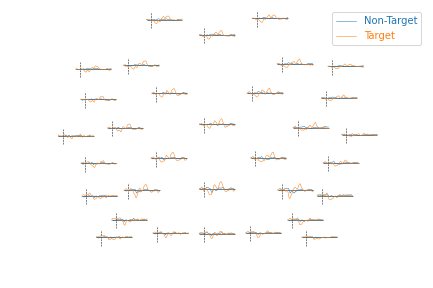

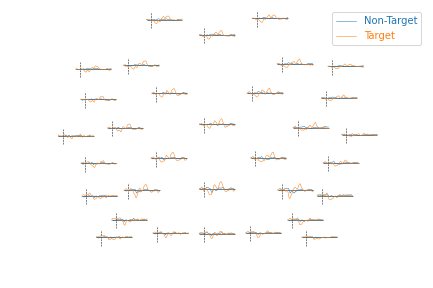

In [28]:
evokeds = [epochs[name].average() for name in ('Non-Target', 'Target')]
mne.viz.plot_evoked_topo(evokeds, layout_scale=1)

### Decoding ERP

In [29]:
X = epochs.get_data()
y = epochs.events[:, -1]

print(X.shape)
print(y.shape)

(636, 32, 410)
(636,)


(260760, 32)


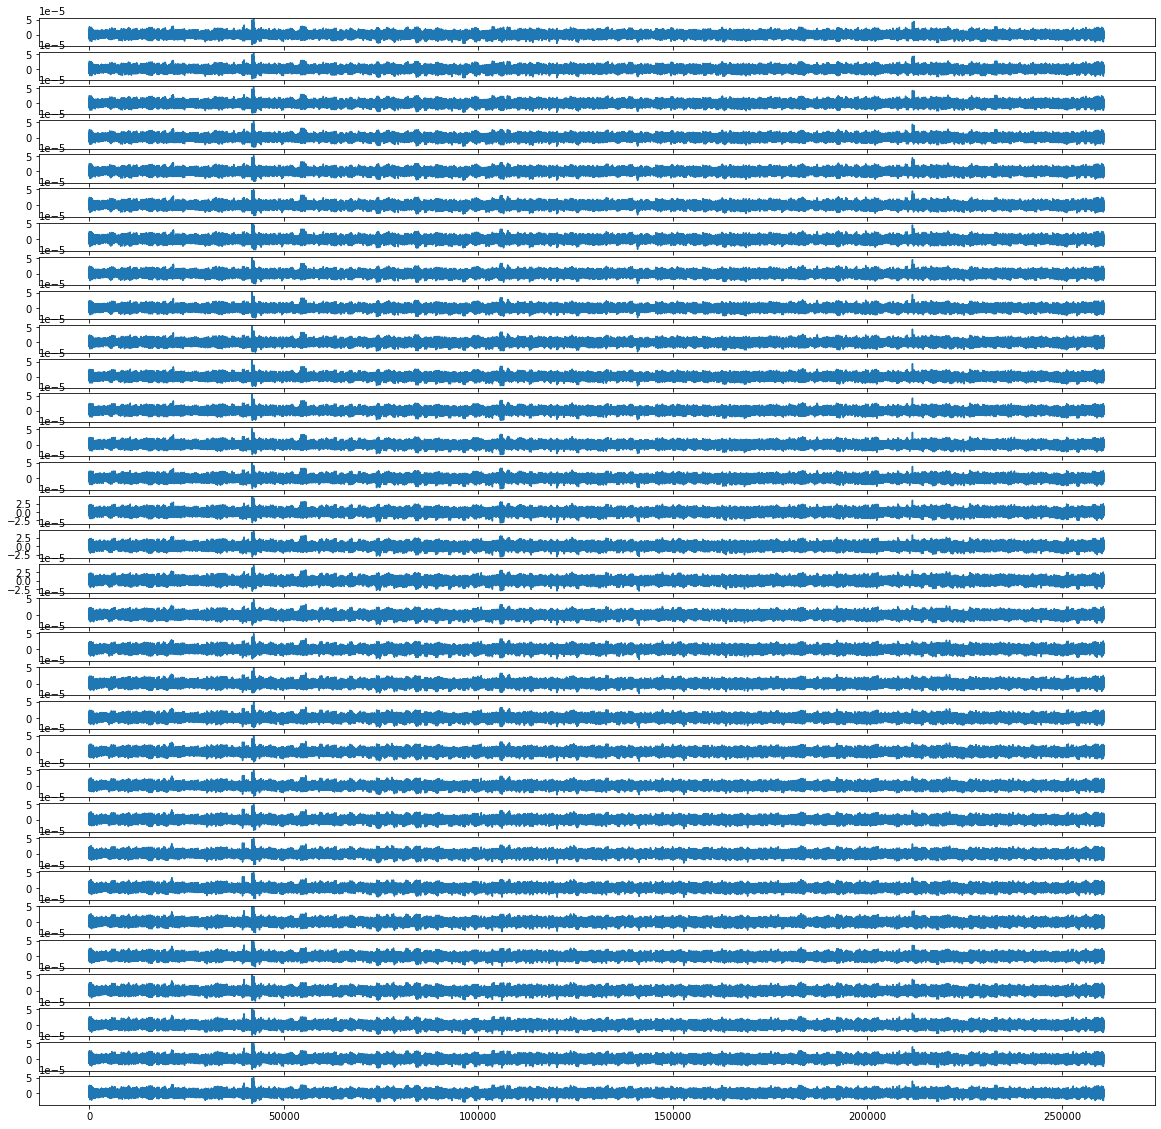

In [30]:
data = X.reshape(-1, 32)
print(data.shape)
fig, ax = plt.subplots(32,1, figsize=(20,20), sharex=True)

for i in range(data.shape[1]):
    ax[i].plot(range(data.shape[0]), data[:, i])

In [31]:
from scipy import signal
from IPython.display import clear_output
import time
import matplotlib

In [32]:
data = X
label = y
print(data.shape)

(636, 32, 410)


In [33]:
data_spectogram = np.zeros((data.shape[0], data.shape[1], 8, 410))
print(data_spectogram.shape)

(636, 32, 8, 410)


In [34]:
fs = 512
nperseg = 15
noverlap = 14
window = 'hann'

for m in range(data.shape[0]):
    for channel in range(data.shape[1]):
        x = data[m,channel,:]

        clear_output(wait=True)
        #y axis = fs/2
        #nperseg = width of yout chunk on the graph
        #15 temporal bins per segment
        f, t, Zxx = signal.stft(x, fs = fs, nperseg=nperseg,noverlap=noverlap)

        data_spectogram[m,channel,:,:] = np.abs(Zxx) #or np.abs(Zxx)

In [35]:

print(data_spectogram.shape)
# print(data_spectogram)

(636, 32, 8, 410)


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [37]:
class Conv2D(nn.Module):
    '''
    Expected Input Shape: (batch, channels, height , width)
    '''
    def __init__(self):
        super(Conv2D, self).__init__()    
        self.conv1 = nn.Sequential(nn.Conv2d(32,16,kernel_size=(3,3),stride=(1,5)),nn.ReLU())
#         self.conv2 = nn.Sequential(nn.Conv2d(32,64,kernel_size=(1,9),stride=(1,5)),nn.ReLU())
#         self.conv3 = nn.Sequential(nn.Conv2d(64,128,kernel_size=(1,2),stride=(1,5)),nn.ReLU())
#         self.conv4 = nn.Sequential(nn.Conv2d(128,256,kernel_size=(1,1),stride=(1,8)),nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(7872,2048),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(2048, 1024), nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(1024, 512), nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(512,250),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(250,125),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(125,50),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(50,2),nn.Dropout(0.1))
#                                nn.Linear(),nn.ReLU()) 
#                                nn.Linear(50000,1000),nn.ReLU(),
#                                nn.Linear(1000,10),nn.ReLU(),)
#         self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,x):
        x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
        x = x.flatten(start_dim = 1)
        x = self.fc(x)
#         x = self.softmax(x)
        return x

In [38]:
model_conv2d = Conv2D()
model_conv2d = model_conv2d.float() #define precision as float to reduce running time

models = [model_conv2d]


In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in models:
    print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model Conv2D has 18,917,531 trainable parameters


In [40]:
import torch.optim as optim

learning_rate = 0.001

# optimizer = optim.Adam(model.parameters())
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


In [42]:
for model in models:
    model = model.to(device)
criterion = criterion.to(device)

In [43]:
torch_X = torch.from_numpy(data_spectogram)
torch_y = torch.from_numpy(y)

In [44]:
torch_y = torch_y-1

In [45]:

print("Original X: ", torch_X.size())

Original X:  torch.Size([636, 32, 8, 410])


In [46]:
torch_X_reshaped = torch_X

In [47]:
from torch.utils.data import TensorDataset

# Define dataset
ds = TensorDataset(torch_X_reshaped, torch_y)

#Train test split
train_size = int(torch_X_reshaped.size()[0] * 0.7)
valid_size = torch_X_reshaped.size()[0] - train_size
# test_size = int(torch_X_reshaped.size()[0] * 0.1) + 1

# train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])
train_set, valid_set = torch.utils.data.random_split(ds, [train_size, valid_size])

BATCH_SIZE = 64 #keeping it binary so it fits GPU
#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

# #Test set loader
# test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
#                                           batch_size=BATCH_SIZE, 
#                                           shuffle=True)

In [48]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []

    trues = []
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        print('================== Predicted y ====================')
        print(predicted)
        predicteds.append(predicted)
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        print('==================    True y   ====================')
        print(labels)
        trues.append(labels)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicteds, trues

In [49]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicteds.append(predicted)
            trues.append(labels)
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues

In [50]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [51]:
print(y.shape)

(636,)


In [52]:
N_EPOCHS = 200

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

for i, model in enumerate(models):
    print(f"Training {type(model).__name__}")
    
    start_time = time.time()

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss, train_acc, train_pred_label, train_true_label = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, valid_pred_label, valid_true_label= evaluate(model, valid_iterator, criterion)
        train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(train_pred_label); train_true_labels.append(train_true_label)
        valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(valid_pred_label); valid_true_labels.append(valid_true_label)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if (epoch+1) % 5 == 0:
            clear_output(wait=True)
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print("Model:{} saved.".format(type(model).__name__))
            # torch.save(model.state_dict(), f'../notebooks_beau/{type(model).__name__}{i}.pth.tar')
            best_model_index = i

Epoch: 200 | Epoch Time: 0m 0s
	Train Loss: 0.465 | Train Acc: 83.15%
	 Val. Loss: 0.446 |  Val. Acc: 83.39%


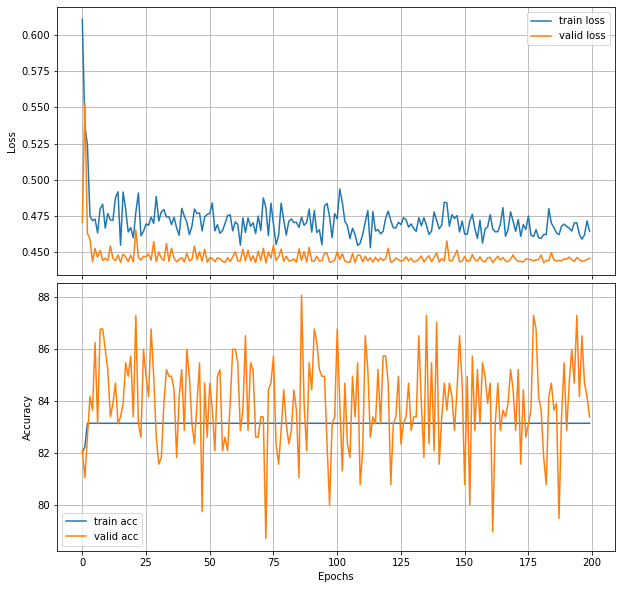

In [53]:

fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()